In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import json
from datetime import date, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [134]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"

#Source NL https://pageviews.wmcloud.org/?project=nl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2020-01-01&end=2020-08-31&pages=Stress|Bezorgdheid|Eenzaamheid|Slapeloosheid|Depressie_(klinisch)
#Source IT https://pageviews.wmcloud.org/?project=it.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2020-01-01&end=2020-08-31&pages=Stress|Ansia|Disturbo_depressivo|Insonnia
#Source PL https://pageviews.wmcloud.org/?project=pl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2020-01-01&end=2020-08-31&pages=L%C4%99k|Zaburzenia_depresyjne|Bezsenno%C5%9B%C4%87%7CSamotno%C5%9B%C4%87%7CStres
#Source SV LOST IT :(

NL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_nl.csv"
IT_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_it.csv"
PL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_pl.csv"
SV_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_sv.csv"

In [135]:
EFFECT_DURATION = 10
LANGUAGES = ['nl', 'sv', 'pl', 'it']
region = {
    'nl':'Netherlands',
    'sv':'Sweden',
    'pl':'Poland',
    'it':'Italy'
}
diseases_names = {
    'en':['anxiety', 'depression', 'insomnia', 'loneliness', 'stress'],
    'nl':['Bezorgdheid', 'Depressie (klinisch)', 'Slapeloosheid', 'Eenzaamheid', 'Stress'],
    'it':['Ansia', 'Disturbo depressivo', 'Insonnia', 'Solitudine', 'Stress'],
    'sv':['Ångest', 'Depression', 'Sömnlöshet', 'Ensamhet', 'Stress'],
    'pl':['Lęk', 'Zaburzenia depresyjne', 'Bezsenność', 'Samotność', 'Stres']
}

In [136]:
interventions_data = pd.read_csv(INTERVENTIONS_DATASET)
apple_mobility_data = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
google_mobility_data = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)

pageviews_data = {}
pageviews_data['nl'] = pd.read_csv(NL_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['it'] = pd.read_csv(IT_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['sv'] = pd.read_csv(SV_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['pl'] = pd.read_csv(PL_PAGEVIEWS_DATASET, low_memory=False)

In [137]:
#Daily pageviews
pageviews_data['it'].head(5)

,Date,Stress,Ansia,Disturbo depressivo,Insonnia,Solitudine
0,2020-01-01,75,175,365,147,75
1,2020-01-02,104,170,466,168,67
2,2020-01-03,91,231,455,213,51
3,2020-01-04,96,220,469,220,65
4,2020-01-05,89,258,569,217,73


In [138]:
interventions_data.set_index('lang', inplace=True)

In [139]:
#augment data with interventions date in poland
interventions_data.loc['pl'] = [np.nan, '2020-03-12', '2020-03-12', np.nan,'2020-03-12', np.nan, np.nan]
interventions_data

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15


In [140]:
for col in interventions_data.columns:
    interventions_data[col] = pd.to_datetime(interventions_data[col])

apple_mobility_data = apple_mobility_data.drop(columns = ['alternative_name', 'country', 'sub-region'], axis=1)

In [141]:
def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang]
    end = interventions_data['Normalcy'].loc[lang]
    if start == pd.NaT or end == pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

In [142]:
def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['month'] = df['Date'].apply(lambda date: date.month) #add month
    df['is_weekend'] = df['Day_of_the_week'].apply(lambda day: 1 if day == 'Saturday' or day == 'Sunday' else 0)

    df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'month', 'is_weekend']]
    return df

In [143]:
get_pageviews_data("pl")

,anxiety,depression,insomnia,loneliness,stress,Day_of_the_week,first_case,first_death,lockdown,month,is_weekend
Date,,,,,,,,,,,
2020-01-01,114,505,181,78,107,Wednesday,0,0,0,1,0
2020-01-02,133,669,286,63,171,Thursday,0,0,0,1,0
2020-01-03,142,645,294,52,189,Friday,0,0,0,1,0
2020-01-04,140,598,235,62,192,Saturday,0,0,0,1,1
2020-01-05,171,663,278,70,200,Sunday,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,109,496,160,49,74,Thursday,0,0,0,8,0
2020-08-28,63,409,142,40,66,Friday,0,0,0,8,0
2020-08-29,78,401,113,66,93,Saturday,0,0,0,8,1


In [144]:
def get_apple_data(lang):
    df = apple_mobility_data.loc[apple_mobility_data['region'] == region[lang]]
    if lang == 'pl': #no transit data for poland
        df.index = ['driving', 'walking']
    else:
        df.index = ['driving', 'transit', 'walking']
    df = df.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
    df = df.T
    df.index = pd.to_datetime(df.index)
    return df

In [145]:
def get_google_data(lang):
    df = google_mobility_data[google_mobility_data['country_region'] == region[lang]]
    df = df[df['sub_region_1'].isna()] #keep only rows with country level data (for italy only using sub_region_1 is enough)
    df = df.dropna(axis=1, how='all') #keep only rows without NaN values(should drop all "sub_region"s)
    df = df.interpolate() #replace NaN values with average of bfill and ffill (No NaN values in this filtered dataframe but not necessarily the case)
    df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
    del df['date']
    df = df.drop_duplicates()
    df.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',
                        'grocery_and_pharmacy_percent_change_from_baseline':'grocery',
                        'parks_percent_change_from_baseline':'parks',
                        'transit_stations_percent_change_from_baseline':'stations',
                        'workplaces_percent_change_from_baseline':'workplaces',
                        'residential_percent_change_from_baseline':'residential'},
                        inplace = True)
    return df

In [146]:
def merge_datasets(pageviews, apple, google):
    df = pd.merge(pageviews, apple, left_index=True, right_index=True)
    df = pd.merge(df, google, left_index=True, right_index=True)
    return df

### Linear Regression


In [147]:
#To store results from regression
it_reg_res = []
nl_reg_res = []
sv_reg_res = []
pl_reg_res = []

In [148]:
def regression(disease, lang, df):
    #Note removed C(month)
    #Bad idea to have highly correlated features in regression, here we judged wise to take average of driving walking (and transit)
    if lang == 'pl': #No transit data for poland
        mod = smf.ols(formula= disease + ' ~ driving + walking + retail + grocery + parks + stations + workplaces + residential + C(first_case) + C(first_death) + C(lockdown) + C(is_weekend)', data=df)
    else:
        mod = smf.ols(formula= disease + ' ~ driving + transit + walking + retail + grocery + parks + stations + workplaces + residential + C(first_case) + C(first_death) + C(lockdown) + C(is_weekend)', data=df)
    np.random.seed(2)
    res = mod.fit()
    if(lang == 'nl'):
        nl_reg_res.append(res)
    elif(lang == 'sv'):
        sv_reg_res.append(res)
    elif(lang == 'pl'):
        pl_reg_res.append(res)
    elif(lang == 'it'):
        it_reg_res.append(res)
    
    print('\n Regression for ' + disease + ' in ' + region[lang] + '\n')
    print(res.summary())

In [149]:
def standardize_non_catergorical_features(df, lang):
    df_categorical = df[["first_case", "first_death", "lockdown", "month", "is_weekend"]]
    df_targets = df[["anxiety",  "depression",  "insomnia", "loneliness", "stress" ]] #dont standardize the targets
    if(lang == 'pl'):
        df_non_categorical = df[["driving", "walking", "retail", "grocery", "parks", "stations", "workplaces", "residential"]]
    else: 
        df_non_categorical = df[["driving", "walking", "retail", "grocery", "parks", "stations", "transit", "workplaces", "residential"]]
        
    df_non_categorical_standardized =  (df_non_categorical - df_non_categorical.mean())/df_non_categorical.std() #standardization
    df_standardized_features = df_non_categorical_standardized.join(df_categorical).join(df_targets)
    #print(df_standardized.head(5))
    return df_standardized_features


In [150]:
def loop(langs, diseases):
    #each array with have 5 elements, one for each disease
    #the order of the diseases will be :  'anxiety', 'depression', 'insomnia', 'loneliness', 'stress'

    for lang in langs:
        pageviews = get_pageviews_data(lang)
        apple = get_apple_data(lang)
        google = get_google_data(lang)
        df = merge_datasets(pageviews, apple, google)
        #print(df);
        df_standardized  = standardize_non_catergorical_features(df, lang) 
        for disease in diseases:
            regression(disease, lang, df_standardized)

In [151]:
loop(LANGUAGES, diseases_names['en'])


 Regression for anxiety in Netherlands

                            OLS Regression Results                            
Dep. Variable:                anxiety   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     3.087
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           0.000547
Time:                        21:02:55   Log-Likelihood:                -524.69
No. Observations:                 191   AIC:                             1075.
Df Residuals:                     178   BIC:                             1118.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### Visualization

Now we can visualize the effect of all the predictors. Let's first sort them by the coefficients.

In [152]:
LANG_TEXTS = ['Dutch', 'Swedish', 'Polish', 'Italian']
def visualise_effect_of_predictors_for_one_subplot(res, lang_idx, disease_idx, n_rows, n_cols, init_num):
    # feature names
    variables = res.params.index
    # quantifying uncertainty!
    # coefficients
    coefficients = res.params.values
    # p-values
    p_values = res.pvalues
    # standard errors
    standard_errors = res.bse.values
    #confidence intervals
    res.conf_int()
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    plt.subplot(n_rows, n_cols, init_num)
    #print(l1)
    plt.title("Language: " + LANG_TEXTS[lang_idx] + ", Disease: " + diseases_names['en'][disease_idx] + ", R^2: " + "{:.2f}".format(res.rsquared))
    #fancy plotting
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
                linestyle = 'none',marker = 'o',markersize= 3,
                markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
        
    plt.vlines(0,0, len(l1), linestyle = '--')
    plt.xticks(range(-100, 101, 20)) #maybe dont need them all to have same number of xticks! because poland, depression is weird when have this
    plt.yticks(range(len(l2)),l2)

In [153]:
def visualize_effect_of_predictors(nl_reg_res, sv_reg_res, pl_reg_res, it_reg_res):
    n_rows = 10 #number of figures per row
    n_cols = 2 #number of figures per col
    #fig, ax = plt.subplots(n_rows, n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (10,35))
    fig.tight_layout(w_pad = 10, h_pad = 3)
    results = []
    subplot_num = 1

    for lang_idx in range(4):
        
        lang = LANGUAGES[lang_idx]
        for disease_idx in range(5):
            if(lang == 'nl'):
                res = nl_reg_res[disease_idx]
            elif(lang == 'sv'):
                res = sv_reg_res[disease_idx]
            elif(lang == 'pl'):
                res = pl_reg_res[disease_idx]
            elif(lang == 'it'):
                res = it_reg_res[disease_idx]
            results.append(res)
            visualise_effect_of_predictors_for_one_subplot(res, lang_idx, disease_idx, n_rows, n_cols, subplot_num)
            subplot_num+=1
            
    fig.suptitle("Visualize effect of predictors on wikipedia pageviews for given diseases and language")
    fig.subplots_adjust(top=0.95)
    plt.show()

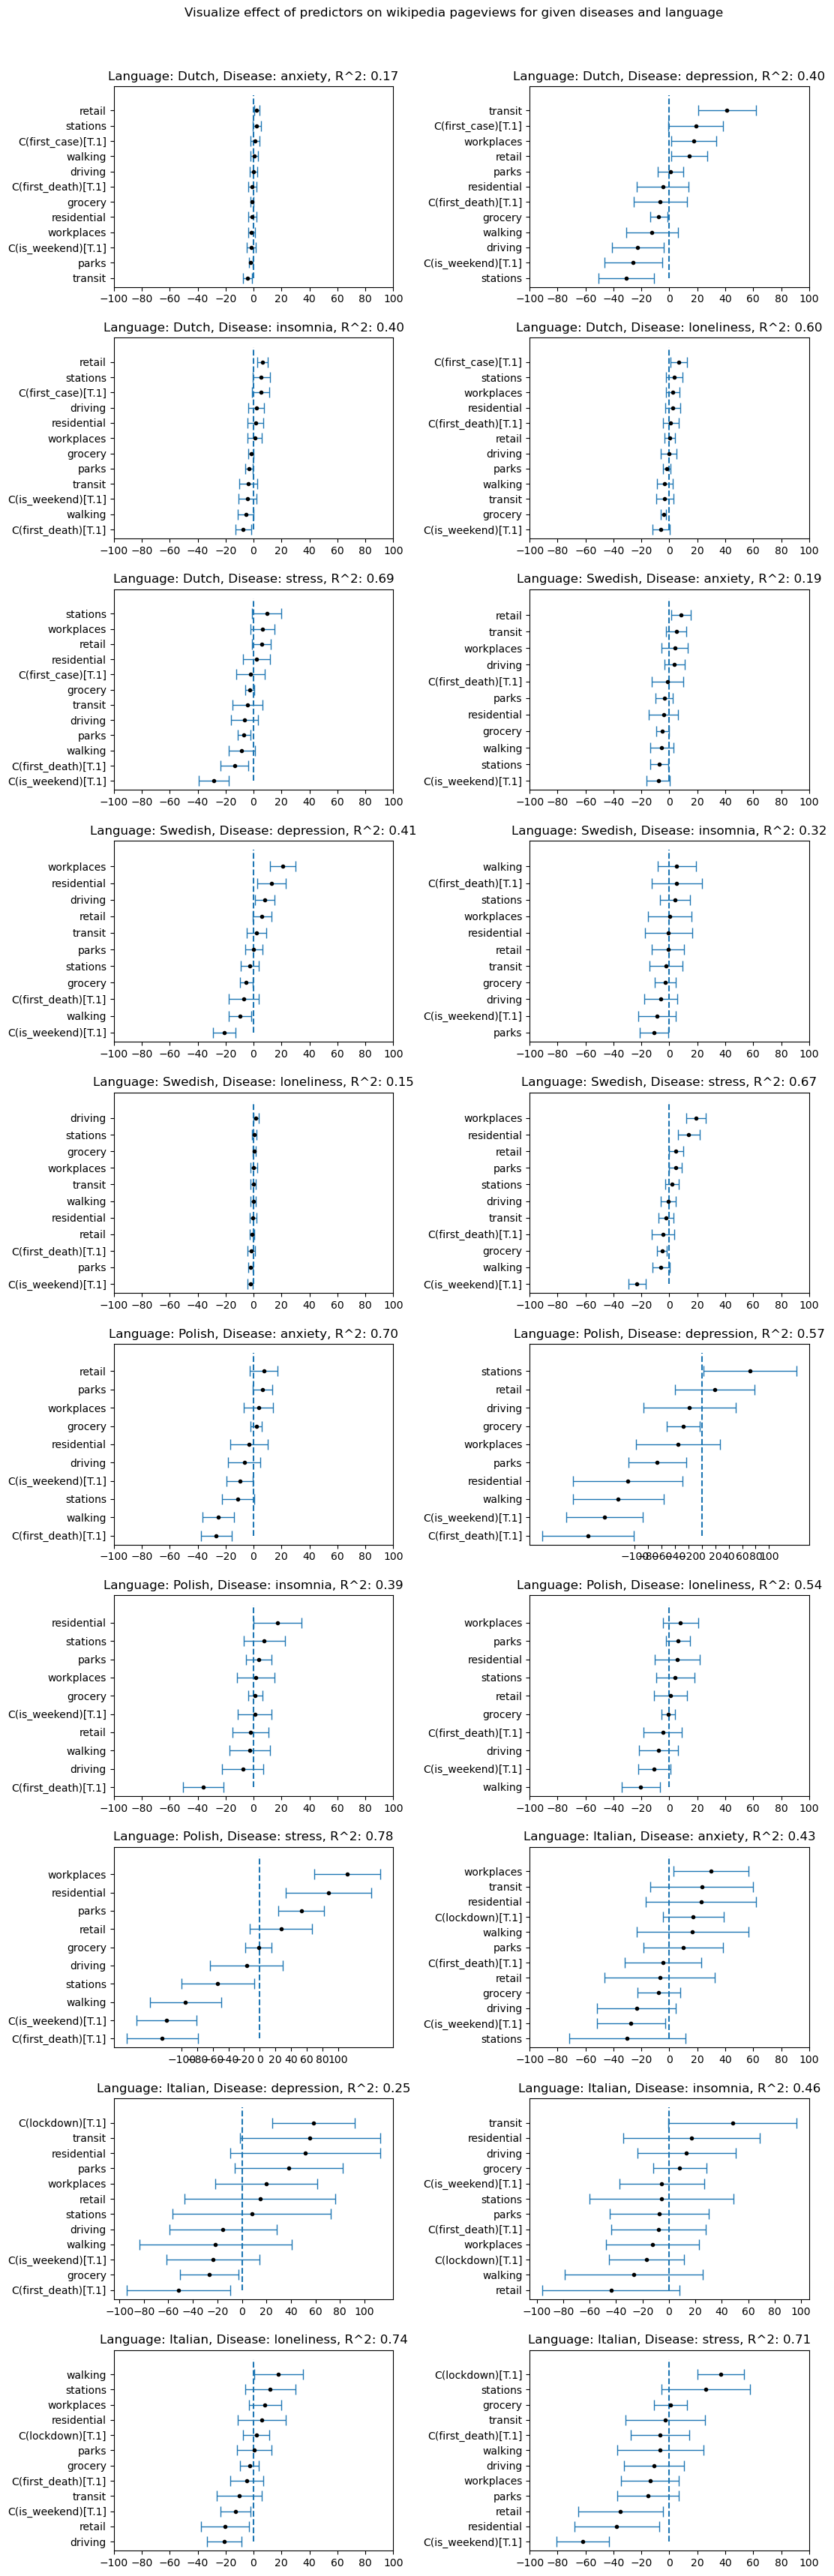

In [154]:
visualize_effect_of_predictors(nl_reg_res, sv_reg_res, pl_reg_res, it_reg_res)

### Try different regression with different features

To avoid highly correlated features in a dataset, we take average of transit, driving, walking from the apple dataset

In [155]:
#To store results from regression
it_reg_res = []
nl_reg_res = []
sv_reg_res = []
pl_reg_res = []

Re-define regression with different features

In [156]:
def standardize_non_catergorical_features_with_mobility_avg(df, lang):
    df_categorical = df[["first_case", "first_death", "lockdown", "month", "is_weekend"]]
    df_targets = df[["anxiety",  "depression",  "insomnia", "loneliness", "stress" ]] #dont standardize the targets
    if(lang == 'pl'):
        df_non_categorical = df[["mobility_avg", "driving", "walking", "retail", "grocery", "parks", "stations", "workplaces", "residential"]]
    else: 
        df_non_categorical = df[["mobility_avg", "driving", "walking", "retail", "grocery", "parks", "stations", "transit", "workplaces", "residential"]]
        
    df_non_categorical_standardized =  (df_non_categorical - df_non_categorical.mean())/df_non_categorical.std() #standardization
    df_standardized_features = df_non_categorical_standardized.join(df_categorical).join(df_targets)
    #print(df_standardized.head(5))
    return df_standardized_features

In [157]:

def get_apple_data_mobility_average(lang):
    df = apple_mobility_data.loc[apple_mobility_data['region'] == region[lang]]
    if lang == 'pl': #no transit data for poland
        df.index = ['driving', 'walking']
    else:
        df.index = ['driving', 'transit', 'walking']
    df = df.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
    df = df.T
    df.index = pd.to_datetime(df.index)
    df['mobility_avg'] = df.mean(axis=1) 
    return df

In [158]:
def loop(langs, diseases, standardize = True):
    #each array with have 5 elements, one for each disease
    #the order of the diseases will be :  'anxiety', 'depression', 'insomnia', 'loneliness', 'stress'

    for lang in langs:
        pageviews = get_pageviews_data(lang)
        apple = get_apple_data_mobility_average(lang)
        #print(apple)
        google = get_google_data(lang)
        df = merge_datasets(pageviews, apple, google)
        #print(df)
        #print(df);
        #df = add_mobility_column(df)
        if(standardize == True):
            df_standardized  = standardize_non_catergorical_features_with_mobility_avg(df, lang) 
        else:
            df_standardized = df
        for disease in diseases:
            regression(disease, lang, df_standardized)
            sns.regplot(x='mobility_avg', y=disease, data=df_standardized)
            plt.show()
        
        
        

In [159]:
def regression(disease, lang, df):
    #Note removed C(month)
    #Bad idea to have highly correlated features in regression, here we judged wise to take average of driving walking (and transit)
    mod = smf.ols(formula= disease + ' ~ mobility_avg', data=df)
    np.random.seed(2)
    res = mod.fit()

    if(lang == 'nl'):
        nl_reg_res.append(res)
    elif(lang == 'sv'):
        sv_reg_res.append(res)
    elif(lang == 'pl'):
        pl_reg_res.append(res)
    elif(lang == 'it'):
        it_reg_res.append(res)
    
    print('\n Regression for ' + disease + ' in ' + region[lang] + '\n')
    print(res.summary())

Create mobility column by averaging transit + driving + walking


 Regression for anxiety in Netherlands

                            OLS Regression Results                            
Dep. Variable:                anxiety   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7.901
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00546
Time:                        21:02:58   Log-Likelihood:                -538.84
No. Observations:                 191   AIC:                             1082.
Df Residuals:                     189   BIC:                             1088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Interce

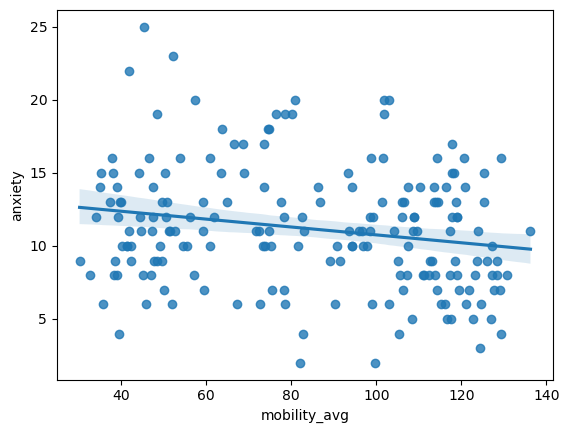


 Regression for depression in Netherlands

                            OLS Regression Results                            
Dep. Variable:             depression   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6217
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.431
Time:                        21:02:58   Log-Likelihood:                -926.03
No. Observations:                 191   AIC:                             1856.
Df Residuals:                     189   BIC:                             1863.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Inte

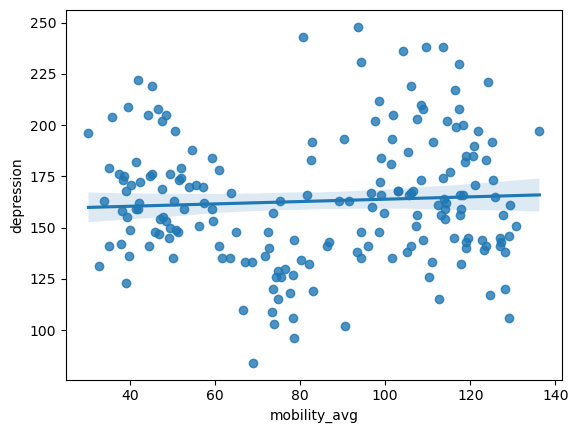


 Regression for insomnia in Netherlands

                            OLS Regression Results                            
Dep. Variable:               insomnia   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5381
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.464
Time:                        21:02:58   Log-Likelihood:                -699.85
No. Observations:                 191   AIC:                             1404.
Df Residuals:                     189   BIC:                             1410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Interc

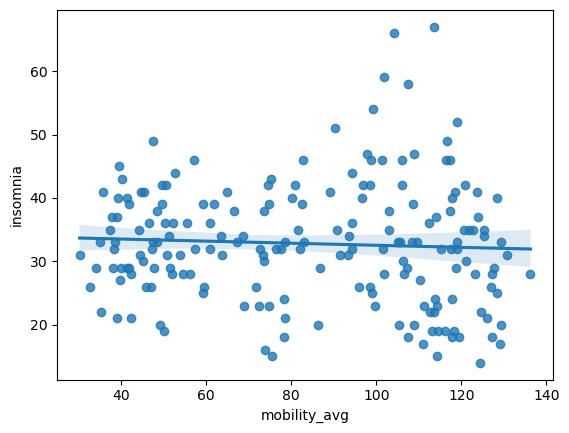


 Regression for loneliness in Netherlands

                            OLS Regression Results                            
Dep. Variable:             loneliness   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     138.4
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           2.49e-24
Time:                        21:02:59   Log-Likelihood:                -680.58
No. Observations:                 191   AIC:                             1365.
Df Residuals:                     189   BIC:                             1372.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Inte

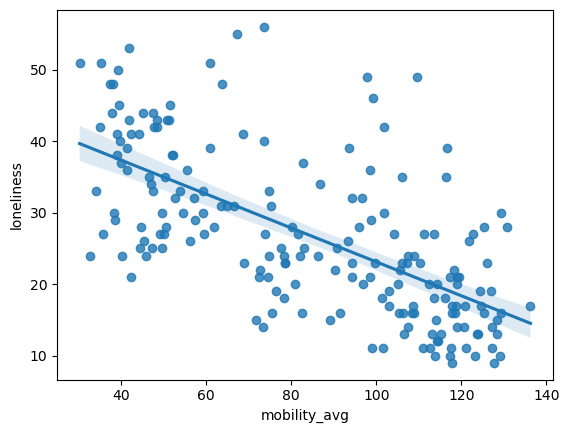


 Regression for stress in Netherlands

                            OLS Regression Results                            
Dep. Variable:                 stress   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     59.38
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           7.16e-13
Time:                        21:02:59   Log-Likelihood:                -836.35
No. Observations:                 191   AIC:                             1677.
Df Residuals:                     189   BIC:                             1683.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

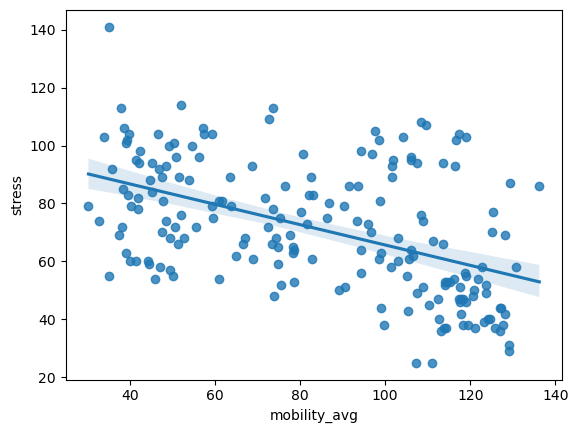


 Regression for anxiety in Sweden

                            OLS Regression Results                            
Dep. Variable:                anxiety   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7661
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.383
Time:                        21:02:59   Log-Likelihood:                -792.40
No. Observations:                 191   AIC:                             1589.
Df Residuals:                     189   BIC:                             1595.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept   

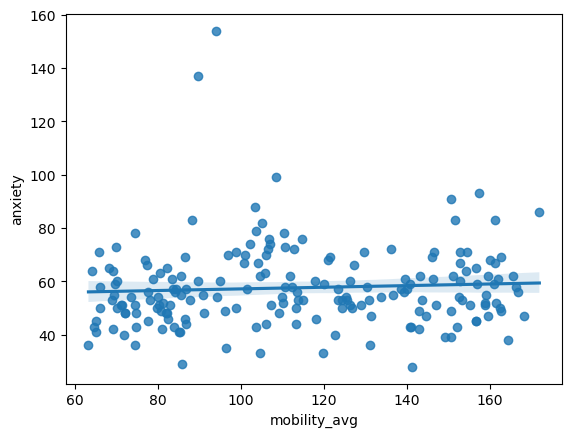


 Regression for depression in Sweden

                            OLS Regression Results                            
Dep. Variable:             depression   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     33.37
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           3.08e-08
Time:                        21:02:59   Log-Likelihood:                -802.49
No. Observations:                 191   AIC:                             1609.
Df Residuals:                     189   BIC:                             1615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept

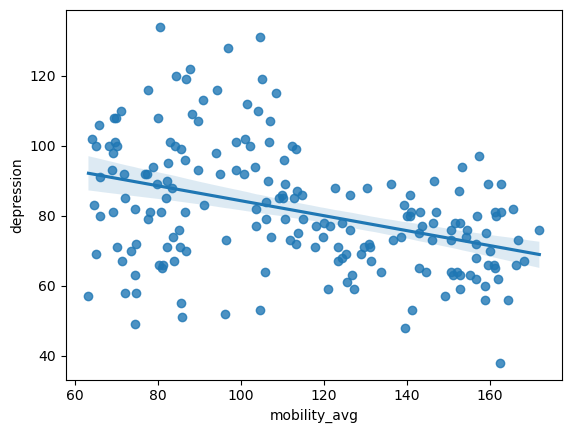


 Regression for insomnia in Sweden

                            OLS Regression Results                            
Dep. Variable:               insomnia   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     44.49
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           2.74e-10
Time:                        21:02:59   Log-Likelihood:                -881.76
No. Observations:                 191   AIC:                             1768.
Df Residuals:                     189   BIC:                             1774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept  

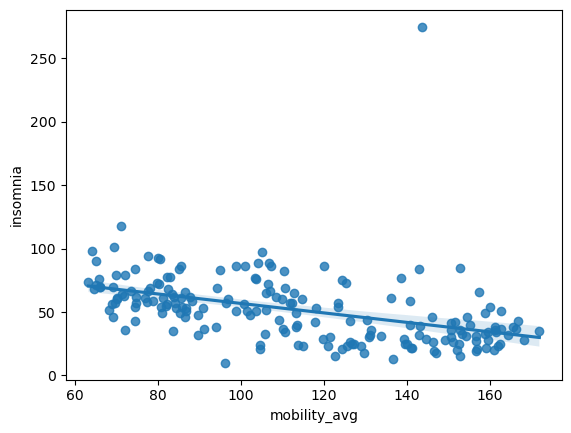


 Regression for loneliness in Sweden

                            OLS Regression Results                            
Dep. Variable:             loneliness   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     5.055
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0257
Time:                        21:03:00   Log-Likelihood:                -513.85
No. Observations:                 191   AIC:                             1032.
Df Residuals:                     189   BIC:                             1038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept

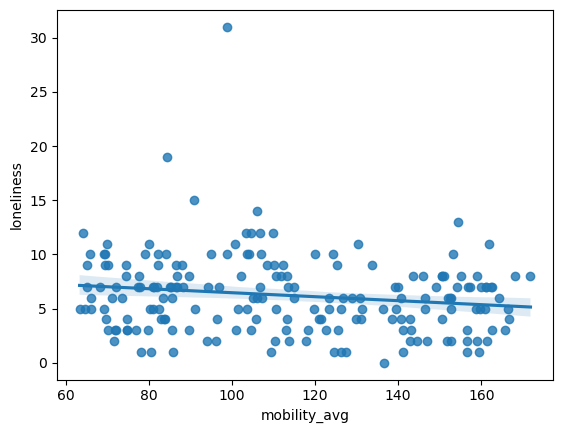


 Regression for stress in Sweden

                            OLS Regression Results                            
Dep. Variable:                 stress   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     149.3
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           1.11e-25
Time:                        21:03:00   Log-Likelihood:                -766.50
No. Observations:                 191   AIC:                             1537.
Df Residuals:                     189   BIC:                             1544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    

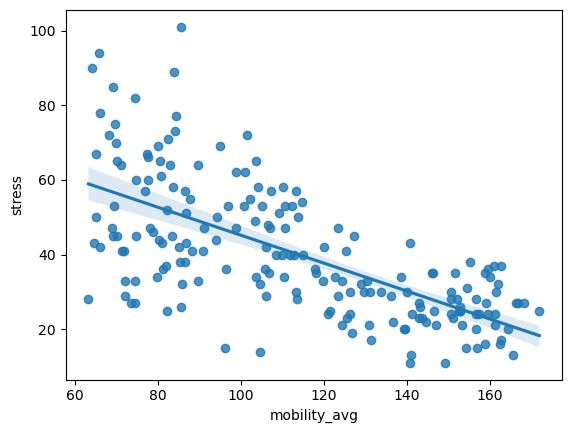


 Regression for anxiety in Poland

                            OLS Regression Results                            
Dep. Variable:                anxiety   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     250.1
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           1.96e-36
Time:                        21:03:00   Log-Likelihood:                -828.22
No. Observations:                 191   AIC:                             1660.
Df Residuals:                     189   BIC:                             1667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept   

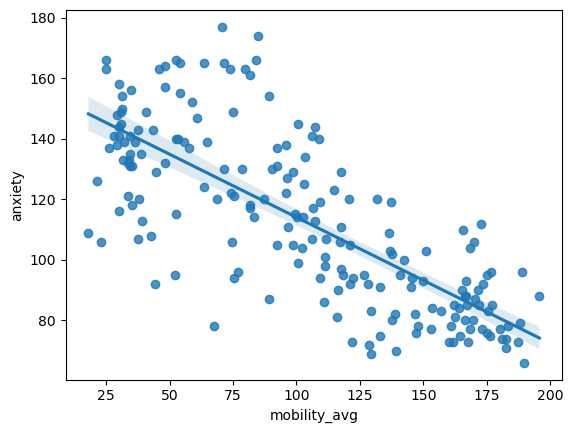


 Regression for depression in Poland

                            OLS Regression Results                            
Dep. Variable:             depression   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     36.31
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           8.64e-09
Time:                        21:03:00   Log-Likelihood:                -1202.5
No. Observations:                 191   AIC:                             2409.
Df Residuals:                     189   BIC:                             2415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept

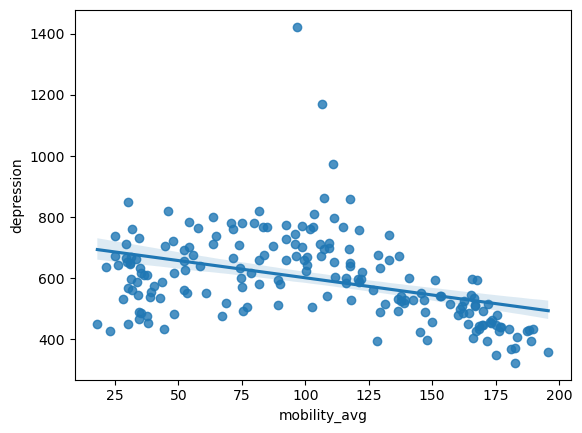


 Regression for insomnia in Poland

                            OLS Regression Results                            
Dep. Variable:               insomnia   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     67.94
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           2.77e-14
Time:                        21:03:01   Log-Likelihood:                -862.51
No. Observations:                 191   AIC:                             1729.
Df Residuals:                     189   BIC:                             1736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept  

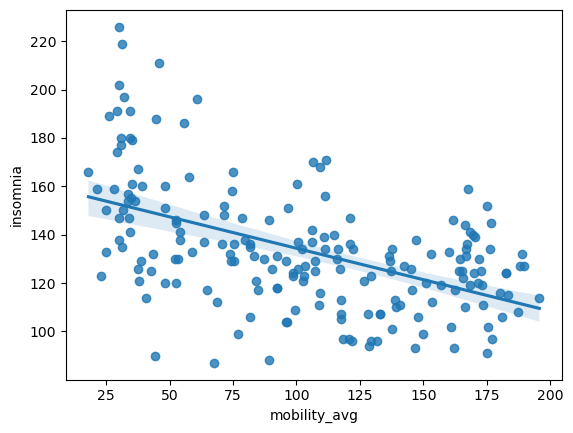


 Regression for loneliness in Poland

                            OLS Regression Results                            
Dep. Variable:             loneliness   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     185.5
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           6.98e-30
Time:                        21:03:01   Log-Likelihood:                -840.32
No. Observations:                 191   AIC:                             1685.
Df Residuals:                     189   BIC:                             1691.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept

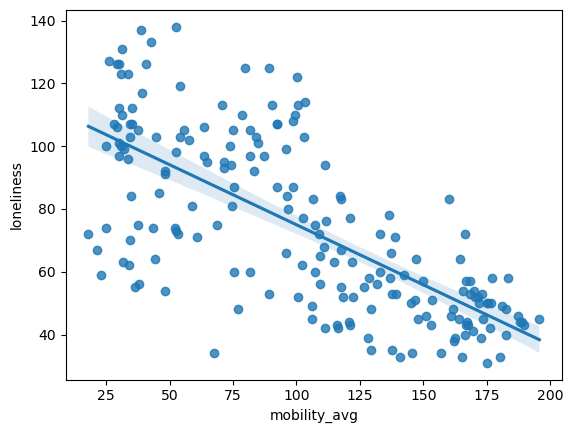


 Regression for stress in Poland

                            OLS Regression Results                            
Dep. Variable:                 stress   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     254.5
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           7.45e-37
Time:                        21:03:01   Log-Likelihood:                -1126.2
No. Observations:                 191   AIC:                             2256.
Df Residuals:                     189   BIC:                             2263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    

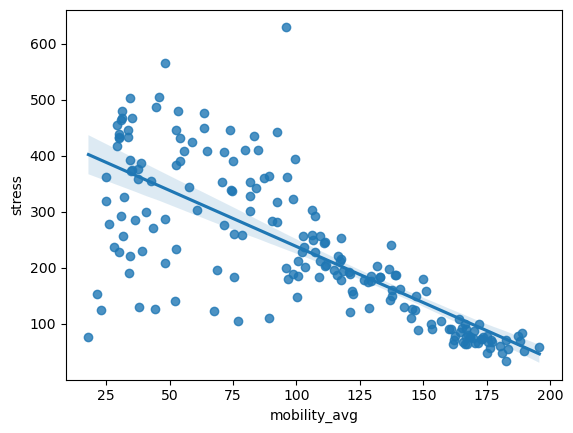


 Regression for anxiety in Italy

                            OLS Regression Results                            
Dep. Variable:                anxiety   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     75.83
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           1.53e-15
Time:                        21:03:01   Log-Likelihood:                -960.37
No. Observations:                 191   AIC:                             1925.
Df Residuals:                     189   BIC:                             1931.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    

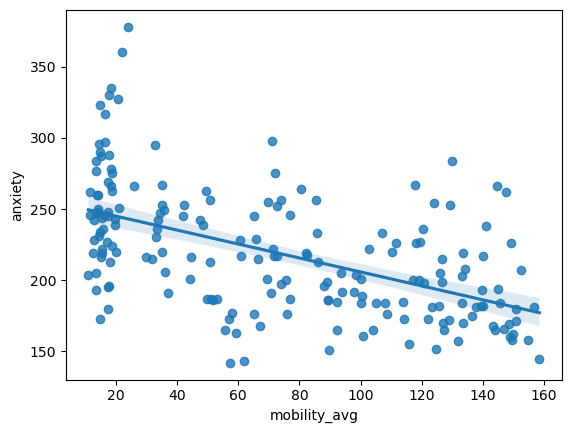


 Regression for depression in Italy

                            OLS Regression Results                            
Dep. Variable:             depression   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.682
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.103
Time:                        21:03:02   Log-Likelihood:                -1049.2
No. Observations:                 191   AIC:                             2102.
Df Residuals:                     189   BIC:                             2109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept 

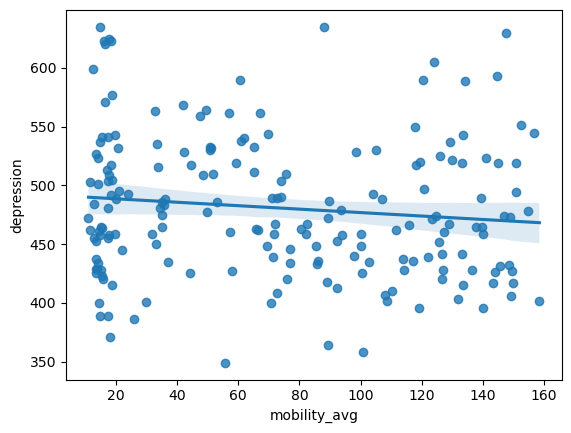


 Regression for insomnia in Italy

                            OLS Regression Results                            
Dep. Variable:               insomnia   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     67.52
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           3.24e-14
Time:                        21:03:02   Log-Likelihood:                -1020.9
No. Observations:                 191   AIC:                             2046.
Df Residuals:                     189   BIC:                             2052.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept   

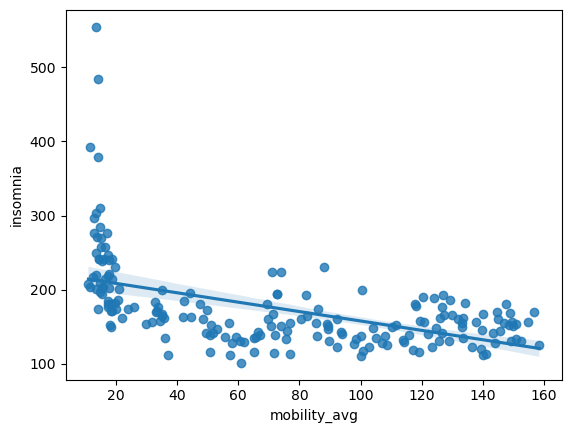


 Regression for loneliness in Italy

                            OLS Regression Results                            
Dep. Variable:             loneliness   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     364.8
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           5.34e-46
Time:                        21:03:02   Log-Likelihood:                -807.25
No. Observations:                 191   AIC:                             1618.
Df Residuals:                     189   BIC:                             1625.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept 

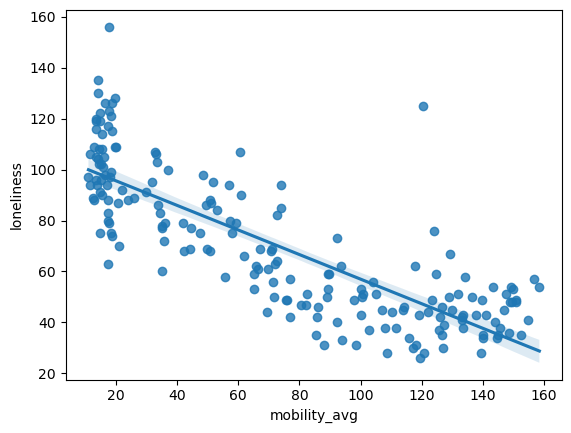


 Regression for stress in Italy

                            OLS Regression Results                            
Dep. Variable:                 stress   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     206.9
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           3.60e-32
Time:                        21:03:02   Log-Likelihood:                -935.64
No. Observations:                 191   AIC:                             1875.
Df Residuals:                     189   BIC:                             1882.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     

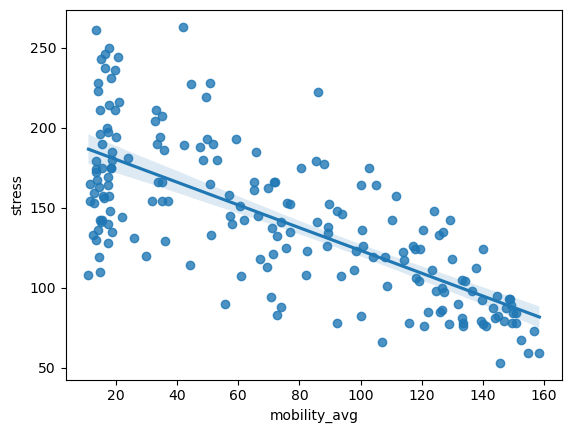

In [160]:
loop(LANGUAGES, diseases_names['en'], standardize=False)

In [177]:
def get_p_values_r_squared(it_reg_res, sv_reg_res, nl_reg_res, pl_reg_res, p_values, r_squared_adj, feature_name = 'mobility_avg'):
        for lang in LANGUAGES:
            for disease_idx in range(5):
                if(lang == 'nl'):
                    res = nl_reg_res[disease_idx]
                elif(lang == 'sv'):
                    res = sv_reg_res[disease_idx]
                elif(lang == 'pl'):
                    res = pl_reg_res[disease_idx]
                elif(lang == 'it'):
                    res = it_reg_res[disease_idx]
                p_values.append(pd.DataFrame(res.pvalues).loc[feature_name][0])
                r_squared_adj.append(res.rsquared_adj)

In [225]:
def visualise_all_p_values_r2adj_of_a_feature(it_reg_res ,sv_reg_res, nl_reg_res, pl_reg_res, feature_name = 'mobility_avg'):
    p_values = []
    r_squared_adj = []
    get_p_values_r_squared(it_reg_res ,sv_reg_res, nl_reg_res, pl_reg_res, p_values, r_squared_adj, feature_name)
    # print(p_values)
    p_vals = np.array([p_values])
    r2adj = np.array([r_squared_adj])
    df_p_vals = pd.DataFrame(p_vals.reshape(4,5))
    df_p_vals = df_p_vals.rename(index={0: 'NL', 1: 'SV', 2: 'PL', 3: 'IT'}, 
                                columns={0: 'Anxiety', 1: 'Depression', 2: 'Insomnia', 3: 'Loneliness', 4: 'Stress'})

    df_r2adj = pd.DataFrame(r2adj.reshape(4,5))
    df_r2adj = df_r2adj.rename(index={0: 'NL', 1: 'SV', 2: 'PL', 3: 'IT'}, 
                                columns={0: 'Anxiety', 1: 'Depression', 2: 'Insomnia', 3: 'Loneliness', 4: 'Stress'})
    
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    
    sns.heatmap(df_p_vals, ax=axs[0], linewidth = 1 , annot = True)
    sns.heatmap(df_r2adj, ax=axs[1], linewidth = 1 , annot = True)
    axs[0].set_title("P-values for" + feature_name )
    axs[1].set_title("Adjusted R2 values")
    axs[0].tick_params(axis="x", rotation=45)
    axs[0].tick_params(axis="y", rotation=0)
    axs[1].tick_params(axis="x", rotation=45)
    axs[1].tick_params(axis="y", rotation=0)

    plt.show()


[0.00546053721953603, 0.4313950010269746, 0.46413920469496117, 2.489484748974334e-24, 7.15926749217874e-13, 0.38252934574381237, 3.0837232258049595e-08, 2.7377605527184786e-10, 0.025706347318616797, 1.1079943962958052e-25, 1.9573884423737887e-36, 8.63716989379945e-09, 2.7651777391534364e-14, 6.975252580158095e-30, 7.45394621320014e-37, 1.527609188364965e-15, 0.10315945099243805, 3.235857462962219e-14, 5.344399299183382e-46, 3.6022207180406793e-32]


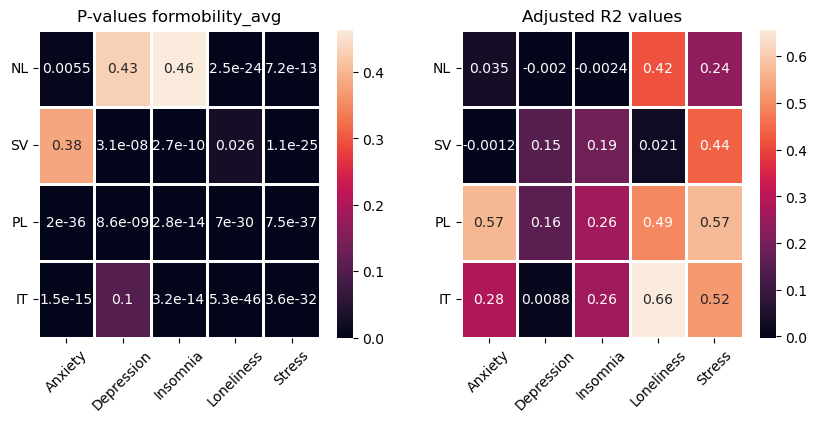

In [226]:
visualise_all_p_values_r2adj_of_a_feature(it_reg_res ,sv_reg_res, nl_reg_res, pl_reg_res, 'mobility_avg')

In [164]:
def visualize_effect_of_one_predictor():
    return 

In [165]:
visualize_effect_of_one_predictor()

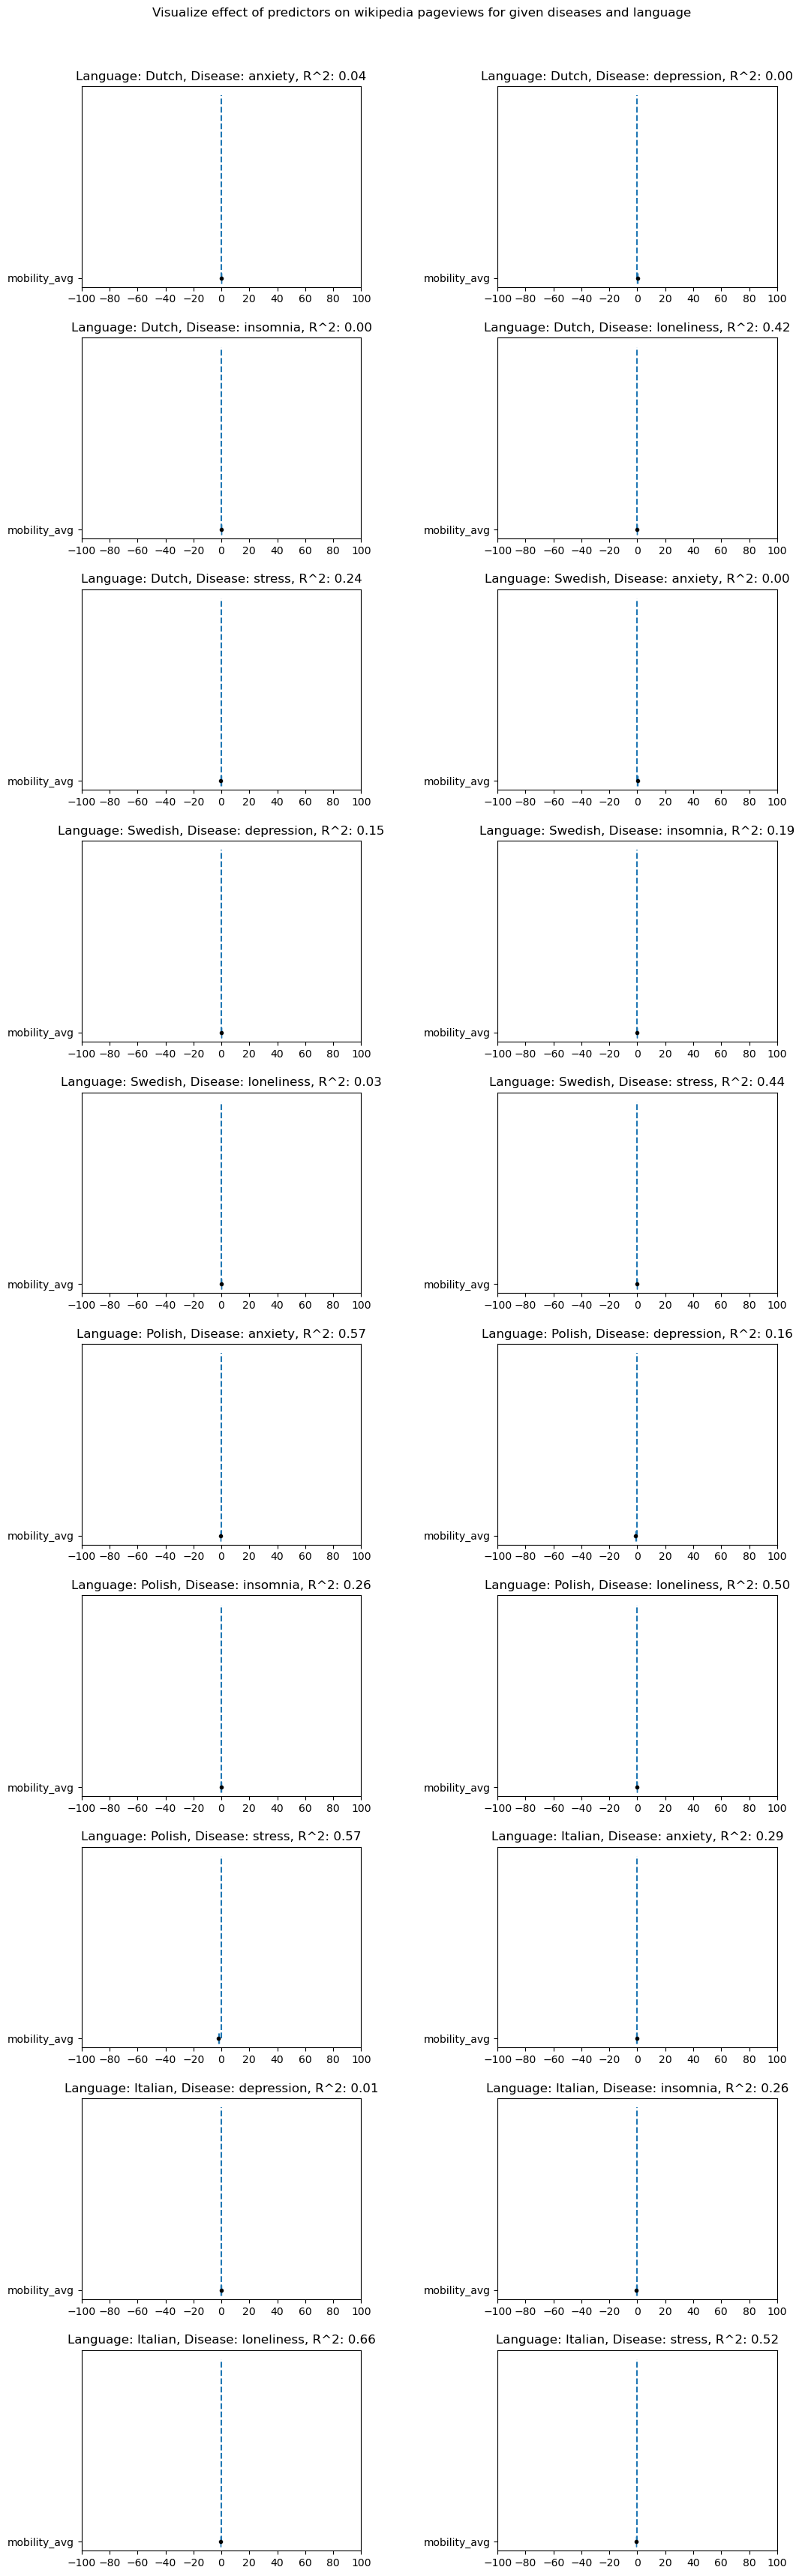

In [166]:
visualize_effect_of_predictors(nl_reg_res, sv_reg_res, pl_reg_res, it_reg_res)